In [1]:
import sbibm
import numpy as np
import torch
import pickle
import pyro
from tqdm import tqdm
from joblib import Parallel, delayed
from pyro.distributions.empirical import Empirical
from functools import reduce

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis

# distances
from scipy.spatial.distance import directed_hausdorff
from torch.nn.functional import normalize

sbibm.get_available_tasks()

['gaussian_mixture',
 'two_moons',
 'slcp',
 'gaussian_linear_uniform',
 'sir',
 'bernoulli_glm',
 'lotka_volterra',
 'gaussian_linear',
 'slcp_distractors',
 'bernoulli_glm_raw']

## Distances

In [12]:
def euclidean(x,y):
    return torch.linalg.norm(x-y,axis=1)

def euclidean_sq(x,y):
    return euclidean(x,y)**2

## Theta selections

First, we have a random selection given the prior

In [4]:
def thetas_from_prior(prior, num_samples = 64):
    return prior(num_samples=num_samples)

In [5]:
def make_theta_grid(prior_min, prior_max, num_points):
    
    assert len(prior_min) == len(prior_max), "prior_min and prior_max must be equal in length"
    assert len(prior_max) == len(num_points), "num_points must be equal in length to prior_min and prior_max"

    coords = []
    for i in range(len(prior_min)):
        coords.append(torch.linspace(prior_min[i], prior_max[i], num_points[i]+2)[1:-1])

    return torch.cartesian_prod(*coords)

In [6]:
def make_theta_covering_grid(thetas, num_points, quantile = 0.98):
    """Produces a grid to cover a set of thetas. Covers each dimension
    by taking central quantile of that dimension according to 'quantile'
    parameter. So, e.g. quantile = 1. gives full cover.

    Args:
        thetas: thetas, such as drawn from prior of a simulator.
        num_points: The number of thetas along each axis of the new 
        quantile: Central quantile. Equivalent for each dimension.

    Returns:
        tensor: thetas representing the grid, each row being one set of parameters.
    """

    assert quantile > 0.5, "please choose quantile > 0.5"

    quant_min = float((1-quantile)/2)
    quant_max = float(quantile + quant_min)

    quantiles = torch.quantile(thetas,torch.tensor([quant_min,quant_max]),axis=0)
    
    prior_max = quantiles[1]
    prior_min = quantiles[0]

    return make_theta_grid(prior_min,prior_max, num_points)

## Lotka Volterra

In [6]:
lk = sbibm.get_task("lotka_volterra")  # See sbibm.get_available_tasks() for all tasks
lk_prior = lk.get_prior()
lk_simulator = lk.get_simulator()
lk_observation = lk.get_observation(num_observation=1)  # 10 per task

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/diffeqtorch/diffeqtorch.py:29: UserWarning: JULIA_SYSIMAGE_DIFFEQTORCH not set
  warn("JULIA_SYSIMAGE_DIFFEQTORCH not set")


In [7]:
lk_simulator(lk_prior(num_samples=1))

JuliaError: Exception 'ArgumentError' occurred while calling julia code:
const PyCall = Base.require(Base.PkgId(Base.UUID("438e738f-606a-5dbb-bf0a-cddfbfd45ab0"), "PyCall"))

## SLCP

In [8]:
slcp = sbibm.get_task("slcp_distractors")  # See sbibm.get_available_tasks() for all tasks
slcp_prior = slcp.get_prior()
slcp_simulator = slcp.get_simulator()
slcp_observation = slcp.get_observation(num_observation=1)  # 10 per task


prior_min = [-3]*5
prior_max = [3]*5
slcp_prior_2 = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))


In [9]:
theta_init = thetas_from_prior(slcp_prior, num_samples=10000)
theta_grid = make_theta_covering_grid(theta_init, [3,3,3,3,3])
thetas_rand = slcp_prior_2.sample((50,))

In [13]:
torch.manual_seed(0)
points_from_grid = slcp_simulator(thetas_rand)
dist_obs = euclidean_sq(points_from_grid,slcp_observation)

In [10]:
# mean_points_from_grid = sum([slcp_simulator(theta_grid) for _ in range(10)])/10
# mean_dist_obs = euclidean(mean_points_from_grid,slcp_observation)

In [14]:
def slcp_simulator_wrapper(theta, seed = None):
    if seed is not None:
        torch.manual_seed(seed)
        # np.random.seed(seed)
        # pyro.set_rng_seed(seed)
    full_data = slcp_simulator(theta)
    return euclidean(points_from_grid, full_data)

In [83]:
# def slcp_simulator_wrapper_mean(theta, seed = None):
#     if seed is not None:
#         torch.manual_seed(seed)
#         # np.random.seed(seed)
#         # pyro.set_rng_seed(seed)
#     full_data = slcp_simulator(theta)
#     return euclidean(mean_points_from_grid, full_data)

In [31]:
slcp_simulator_wrapper(torch.tensor([1.5,1.5,1.5,1.5,1.5]),0)-slcp_simulator_wrapper(torch.tensor([1.5,1.5,1.5,1.5,2]),0)

tensor([-0.0030, -0.0051, -0.0120, -0.0040, -0.0027, -0.0040,  0.0026, -0.0137,
        -0.0109, -0.0018, -0.0038, -0.0020, -0.0039, -0.0037, -0.0034, -0.0007,
        -0.0043, -0.0019, -0.0056, -0.0075, -0.0027, -0.0020, -0.0040, -0.0045,
        -0.0021, -0.0067, -0.0056, -0.0089,  0.0019, -0.0069, -0.0048, -0.0034,
        -0.0039,  0.0002, -0.0008, -0.0069, -0.0005, -0.0065, -0.0059, -0.0027,
        -0.0027, -0.0028, -0.0003,  0.0002, -0.0018, -0.0015, -0.0101, -0.0007,
        -0.0044, -0.0012, -0.0039, -0.0043, -0.0080, -0.0045, -0.0159, -0.0013,
        -0.0041, -0.0020, -0.0048, -0.0028,  0.0030,  0.0023,  0.0010,  0.0019,
        -0.0053, -0.0040, -0.0047, -0.0032, -0.0045,  0.0033, -0.0042,  0.0066,
        -0.0048,  0.0023, -0.0106, -0.0024, -0.0055, -0.0055, -0.0020, -0.0038,
        -0.0020, -0.0061,  0.0005, -0.0045, -0.0018, -0.0065, -0.0042, -0.0096,
         0.0000, -0.0062, -0.0107, -0.0020, -0.0035, -0.0043, -0.0042, -0.0020,
        -0.0023, -0.0061, -0.0006, -0.00

In [57]:
# Use torch prior. By checking code we can see their prior is simply uniform -3,3 on all dimensions.

# class prior_wrapper:

#     def __init__(prior):
#         self.prior

#     def sample(sample_shape):
#         native_shape = slcp_prior(num_samples=1).shape[1]
#         num_samples=reduce(lambda x,y: x*y, sample_shape)
#         samples=slcp_prior(num_samples = num_samples)
#         print(samples)
#         return samples.reshape(sample_shape+(native_shape,))

In [77]:
posterior=infer(slcp_simulator_wrapper, slcp_prior_2, method='SNPE', 
                  num_simulations=500, num_workers=7)

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

 Neural network successfully converged after 42 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

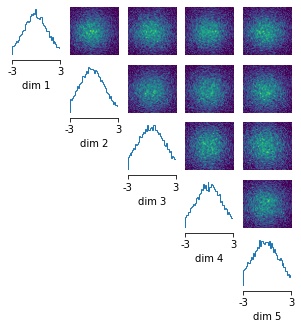

In [78]:
samples = posterior.sample((10000,),x=dist_obs)
fig, axes = analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

 Neural network successfully converged after 78 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

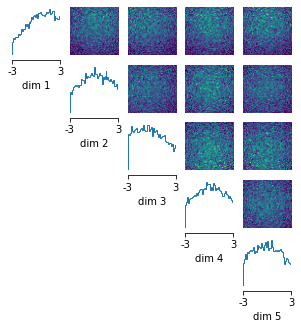

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9967 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


In [18]:
num_rounds = 10
posteriors = []
simulator, prior = prepare_for_sbi(slcp_simulator_wrapper, slcp_prior_2)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(dist_obs)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                            ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                            figsize=(5,5),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

 Neural network successfully converged after 35 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

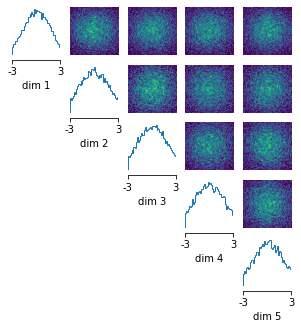

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9920 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


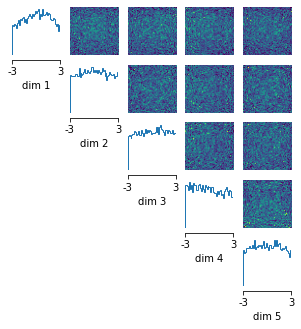

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 802 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9992 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


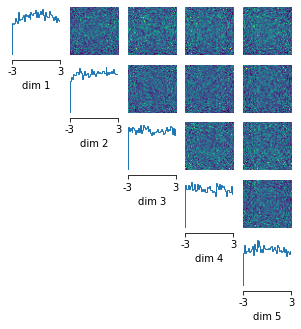

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 992 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 12

KeyboardInterrupt: 

In [85]:
num_rounds = 10
posteriors = []
simulator, prior = prepare_for_sbi(slcp_simulator_wrapper_mean, slcp_prior_2)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(mean_dist_obs)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                            ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                            figsize=(5,5),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

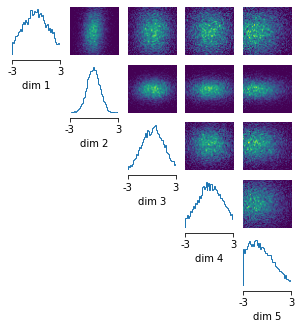

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9955 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


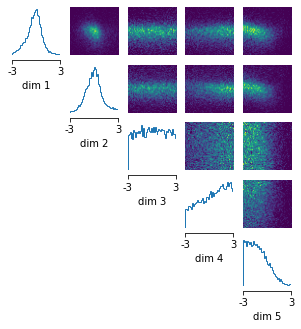

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 943 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9980 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


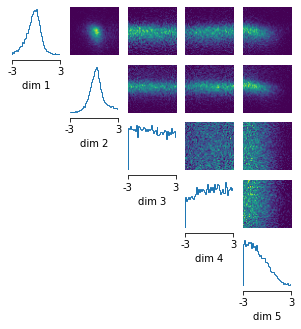

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 969 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9964 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


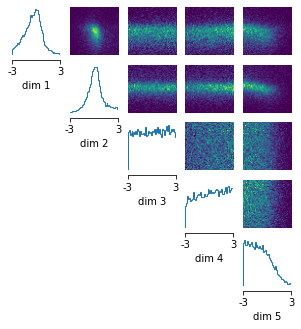

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 963 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9968 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


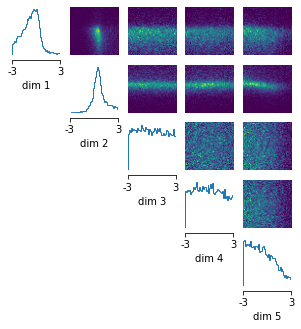

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 960 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9991 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


In [80]:
# Try the full simulator sans grid.

num_rounds = 10
posteriors = []
simulator, prior = prepare_for_sbi(slcp_simulator, slcp_prior_2)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(slcp_observation)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                            ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                            figsize=(5,5),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

## Bernoulli GLM

In [8]:
bglm = sbibm.get_task("bernoulli_glm_raw")  # See sbibm.get_available_tasks() for all tasks
bglm_prior = bglm.get_prior()
bglm_simulator = bglm.get_simulator()
bglm_observation = bglm.get_observation(num_observation=1)  # 10 per task

In [9]:
bglm_simulator(bglm_prior(num_samples=1))

tensor([[1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
         0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
         0., 1., 1., 0., 0., 0., 0., 0., 1., 1.]])

## Roughs

In [5]:
from shutil import which

In [6]:
which('julia')

'/usr/bin/julia'

In [5]:
which('julia')

NameError: name 'which' is not defined

In [22]:
thetas=thetas_from_prior(slcp_prior)

In [23]:
torch.quantile(thetas,torch.tensor([0.01,0.99]),axis=0)

tensor([[-2.4606, -2.8583, -2.8966, -2.8451, -2.5937],
        [ 2.8292,  2.9625,  2.6828,  2.8446,  2.9501]])

In [39]:
thetas=thetas_from_prior(slcp_prior, num_samples=100)

In [42]:
len(grid_from_thetas(thetas, [3,3,3,3,3]))

243

In [49]:
torch.max(thetas_from_prior(slcp_prior, num_samples=100),axis=0)

torch.return_types.max(
values=tensor([2.9549, 2.9946, 2.9966, 2.9620, 2.9799]),
indices=tensor([93, 32, 90, 12, 88]))

In [56]:
slcp_simulator(slcp_prior(num_samples=2))-slcp_simulator(slcp_prior(num_samples=1))

tensor([[ 4.6905e+01,  3.8513e+01, -3.6719e+01,  4.3960e+00, -2.5489e+01,
          2.9771e+01,  1.7049e+01, -4.3741e+01, -7.5740e+01,  2.3122e+01,
         -6.9936e+01,  2.3945e+01,  5.1775e+01, -4.0038e+01, -1.3758e+01,
          4.7499e+00,  3.2156e-01,  5.7098e+00, -2.7793e+01,  1.0761e+01,
          3.3086e+01,  4.0035e+00, -1.0636e+01, -5.5273e+00,  2.2196e+01,
          6.8330e+00, -2.3091e+01, -8.7082e-01,  1.3718e+01, -1.5946e+01,
         -1.8956e+00, -4.1534e+01, -5.1528e+01,  6.1730e+00, -7.2465e+00,
          4.6871e+01, -8.8457e+00, -1.6502e+00,  6.8668e+01,  4.0640e+01,
          1.6911e+01,  2.6882e+01,  9.2362e+00, -9.3312e+00, -2.2027e+00,
          7.7263e+00,  3.0861e+01, -3.2005e+01,  1.8362e+01,  3.7284e-01,
         -4.0343e+01, -1.7503e+00,  1.7345e+00,  6.7796e+00,  2.3490e+01,
         -1.4664e+01, -2.2125e+01, -1.5570e+01, -2.1543e+01, -4.1263e+01,
         -3.5229e-01,  5.0566e+00,  1.0367e+01,  6.9904e-01, -3.6598e+01,
          4.2403e+01,  1.5667e+00,  5.

In [63]:
torch.linalg.norm(torch.tensor([[1.,2.,3.,4.],[5.,6.,7.,8.]])-torch.tensor([[1,2,3,4]]),axis=1)

tensor([0., 8.])

In [27]:
slcp_prior(num_samples = 4).reshape((2,2,5))

tensor([[[ 2.0066,  1.3776,  0.3547, -1.5249, -1.2126],
         [ 1.8588, -1.9196,  0.6148, -0.9338,  1.8953]],

        [[-0.7968,  1.2099, -1.5395, -1.0029,  1.0393],
         [ 0.4220, -2.0784,  1.2365, -0.0031, -2.8234]]])

In [28]:
test = slcp_prior(num_samples = 4)

In [29]:
test

tensor([[ 1.8541, -1.7825, -0.7423,  1.1530,  1.9425],
        [ 2.2943, -1.3780, -2.8260, -2.3799, -1.8921],
        [ 0.3854, -0.5076, -1.5441, -2.9648, -0.0449],
        [ 2.3902,  2.0351,  1.8026,  2.1446, -1.0369]])

In [31]:
test.reshape(4,5)

tensor([[ 1.8541, -1.7825, -0.7423,  1.1530,  1.9425],
        [ 2.2943, -1.3780, -2.8260, -2.3799, -1.8921],
        [ 0.3854, -0.5076, -1.5441, -2.9648, -0.0449],
        [ 2.3902,  2.0351,  1.8026,  2.1446, -1.0369]])

In [33]:
(1000,)+(5,)

(1000, 5)

In [50]:
slcp_prior(num_samples=2).numel()//2

5

In [43]:
test.shape.count(1)

0

In [63]:
slcp_prior_wrapper((3,2))

tensor([[ 2.6902, -1.5216,  1.4196, -2.0726, -1.3471],
        [-2.9673, -0.4120, -2.0009, -1.8368,  2.1254],
        [-0.8766, -0.3250,  2.7962, -0.9066, -2.9434],
        [ 1.1886,  2.3640,  1.4114, -0.1035, -1.6308],
        [ 2.7167,  2.9956,  0.8606,  1.5487,  1.7523],
        [ 2.0399,  2.1522,  1.5918, -2.8099, -0.6320]])


tensor([[[ 2.6902, -1.5216,  1.4196, -2.0726, -1.3471],
         [-2.9673, -0.4120, -2.0009, -1.8368,  2.1254]],

        [[-0.8766, -0.3250,  2.7962, -0.9066, -2.9434],
         [ 1.1886,  2.3640,  1.4114, -0.1035, -1.6308]],

        [[ 2.7167,  2.9956,  0.8606,  1.5487,  1.7523],
         [ 2.0399,  2.1522,  1.5918, -2.8099, -0.6320]]])

In [56]:
from functools import reduce

In [59]:
reduce(lambda x,y:x*y, (3,2,1))

6

In [64]:
prepare_for_sbi(slcp_simulator, slcp_prior)

AttributeError: Prior needs method `.sample()`. Consider using a PyTorch distribution.